# 0-) IMPORTS

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf


from tensorflow.keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers   import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import VGG16

from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
from sklearn.metrics         import classification_report

import warnings
warnings.filterwarnings("ignore")

# 1-) DATA ANALYSIS

In [4]:
batch_size = 4

In [5]:
#load data
dataset = "Drug Vision/Data Combined"
image_dir = Path(dataset)

filepaths = list(image_dir.glob(r"**/*.jpg")) + list(image_dir.glob(r"**/*.png"))
labels    = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths,name="filepath").astype("str")
labels    = pd.Series(labels,name="labels")

image_df  = pd.concat([filepaths,labels],axis=1)

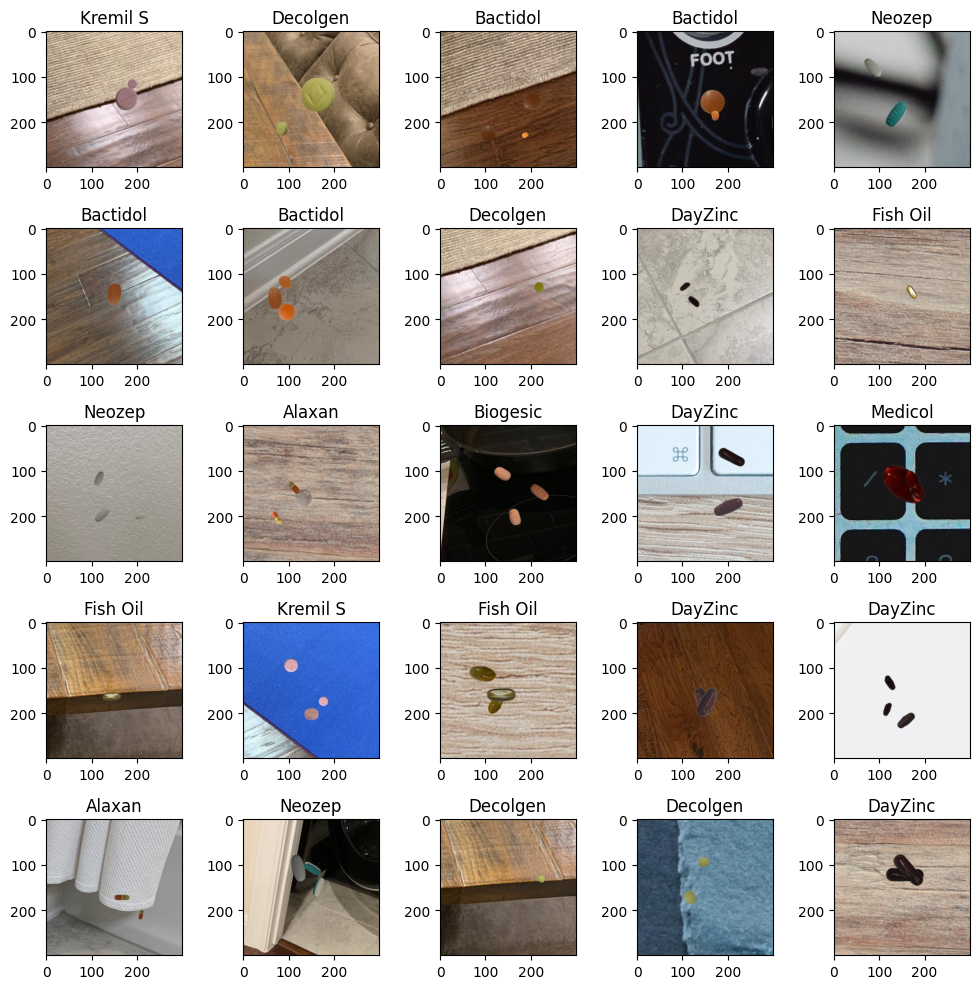

In [6]:
#Data Visualization
random_index = np.random.randint(0,len(image_df),25)

fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    ax.set_title(image_df.labels[random_index[i]])
plt.tight_layout()

In [7]:
#train test split
train_df, test_df=train_test_split(image_df,test_size=0.2,random_state=42, shuffle=True)

print(f"len of train set: {len(train_df)}")
print(f"len of test  set: {len(test_df)}")

len of train set: 8000
len of test  set: 2000


In [8]:
# Data augmentation
train_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                     validation_split=0.2)
test_generator  = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [9]:
#load to flow
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col="filepath",
                                                   y_col="labels",
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset="training")

val_images   = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col="filepath",
                                                   y_col="labels",
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset="validation")

test_images  = train_generator.flow_from_dataframe(dataframe=test_df,
                                                   x_col="filepath",
                                                   y_col="labels",
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=batch_size)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


# 2-) MODELLING

In [10]:
#vgg16
pretrained_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights    ="imagenet",
                         pooling    ="avg")
pretrained_model.trainable= False

In [11]:
#callbacks
checkpoints_pack = "checkpoints"
checkpoint_callback = ModelCheckpoint(checkpoints_pack,
                                      monitor            = "val_loss",
                                      mode               = "min",
                                      save_best_only     = True,
                                      save_weights_only  = True)

early_stopping =  EarlyStopping(monitor  = "val_loss",
                                patience = 5,         
                                verbose  = 1,                  
                                mode     = "min",
                                restore_best_weights = True),      

In [12]:
inputs = tf.keras.Input(shape=(224,224,3))
x = pretrained_model(inputs)  # VGG16'nın özellik çıkarma kısmı
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570  

In [15]:
model.compile(loss    = "categorical_crossentropy",
              optimizer = Adam(learning_rate=1e-4),
              metrics = [tf.keras.metrics.Precision(name="precision"),    
                         tf.keras.metrics.Recall(name="recall"),
                         tf.keras.metrics.AUC(name="auc"),
                         "accuracy"])

In [16]:
history = model.fit(train_images,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    epochs=100,
                    callbacks=[early_stopping,checkpoint_callback])

Epoch 1/100
1600/1600 [==============================] - 59s 37ms/step - loss: 1.8076 - precision: 0.6383 - recall: 0.2920 - auc: 0.8181 - accuracy: 0.4502 - val_loss: 0.8743 - val_precision: 0.8869 - val_recall: 0.5394 - val_auc: 0.9595 - val_accuracy: 0.7350
Epoch 2/100
1600/1600 [==============================] - 31s 20ms/step - loss: 0.8760 - precision: 0.8257 - recall: 0.6047 - auc: 0.9546 - accuracy: 0.7191 - val_loss: 0.6090 - val_precision: 0.9039 - val_recall: 0.7113 - val_auc: 0.9781 - val_accuracy: 0.8181
Epoch 3/100
1600/1600 [==============================] - 32s 20ms/step - loss: 0.6330 - precision: 0.8658 - recall: 0.7200 - auc: 0.9756 - accuracy: 0.7942 - val_loss: 0.5279 - val_precision: 0.9064 - val_recall: 0.7744 - val_auc: 0.9821 - val_accuracy: 0.8325
Epoch 4/100
1600/1600 [==============================] - 32s 20ms/step - loss: 0.4729 - precision: 0.8984 - recall: 0.7962 - auc: 0.9858 - accuracy: 0.8438 - val_loss: 0.4645 - val_precision: 0.9119 - val_recall: 0.80

# 3-) TESTING

In [17]:
def test_set_evaluate(model,test_generator):
    test_loss, test_precision, test_recall, test_auc, test_accuracy = model.evaluate(test_generator)

    print("\nTest Accuracy: %.6f%%" % (100.0 * test_accuracy))
    print("\nTest Loss: %.6f%%" % (100.0 * test_loss))
    print("\nTest Precision: %.6f%%" % (100.0 * test_precision))
    print("\nTest Recall: %.6f%%" % (100.0 * test_recall))
    print("\nTest AUC: %.6f%%" % (100.0 * test_auc))

In [18]:
test_set_evaluate(model, test_images)

500/500 [==============================] - 9s 18ms/step - loss: 0.3804 - precision: 0.9117 - recall: 0.8575 - auc: 0.9884 - accuracy: 0.8815

Test Accuracy: 88.150007%

Test Loss: 38.036156%

Test Precision: 91.174906%

Test Recall: 85.750002%

Test AUC: 98.840004%


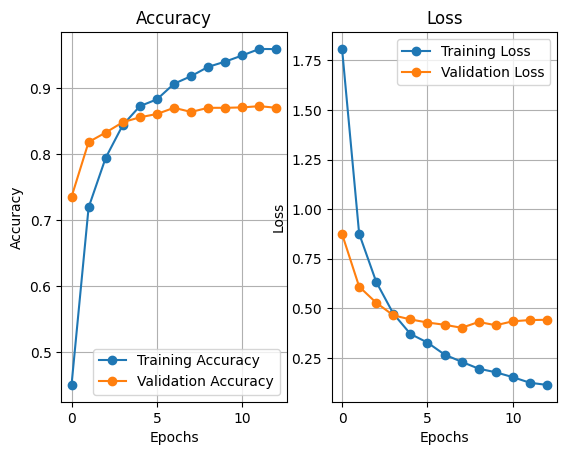

In [19]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"],
         marker = "o",
         label  = "Training Accuracy" )
plt.plot(history.history["val_accuracy"],
         marker = "o",
         label  = "Validation Accuracy" )
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"],
         marker = "o",
         label  = "Training Loss" )
plt.plot(history.history["val_loss"],
         marker = "o",
         label  = "Validation Loss" )
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

500/500 [==============================] - 8s 15ms/step


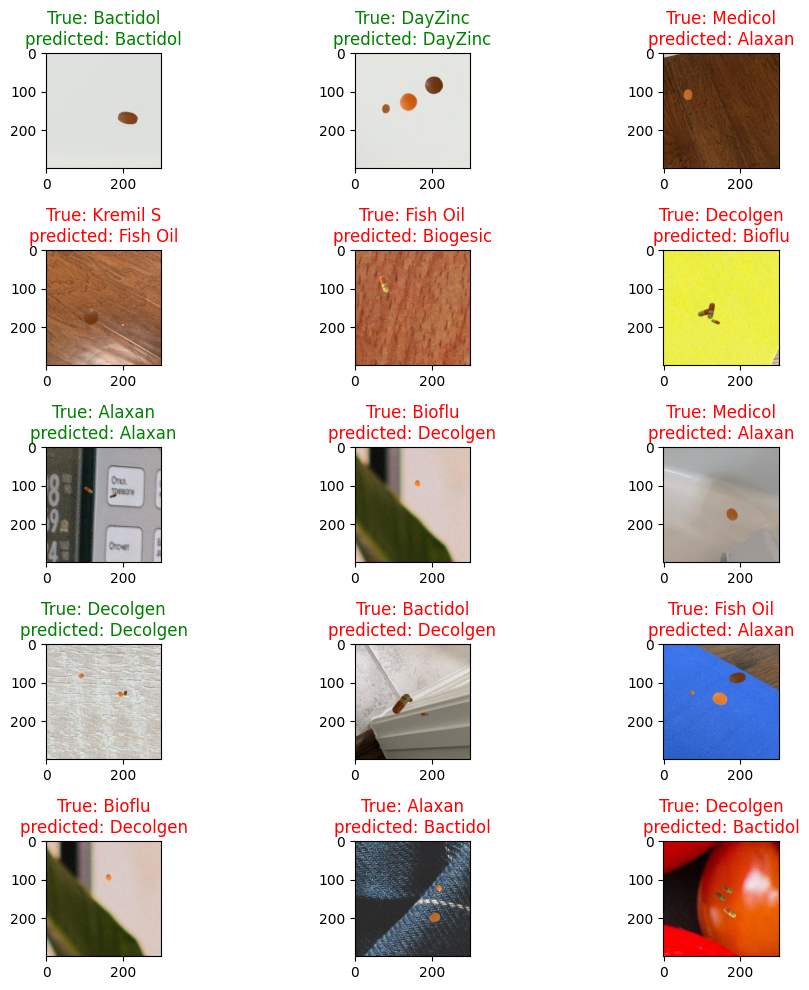

In [24]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = train_images.class_indices
labels = dict((v,k) for k,v in labels.items())

pred = [labels[k] for k in pred]
random_index = np.random.randint(0, len(test_df)-1,15)
fig,axes= plt.subplots(nrows=5,ncols=3,figsize=(10,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]}\npredicted: {pred[random_index[i]]}", color = color)
plt.tight_layout()